# Polynomial regression of time of cell cycle in occipital and frontal cortex

In [1]:
# imports
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV
from sklearn.preprocessing import PolynomialFeatures

# Loading and preprocessing

In [2]:
# load model
df = pd.read_csv("/home/nathan/Desktop/ode_model/_TLVanalysis-division+migration_v7-2_sheet1.csv")
df["Condition"] = df["Condition"].replace(pd.NA, '@', regex=True)

red = df.filter(["Age", "Condition", "Tc..h.", "Region", 'Time_division..DIV.'])
red["Age"] = red["Age"].replace(pd.NA, '@', regex=True)
print(red.shape, "begin")
red = red.loc[red["Age"].str.isalnum()]
print(red.shape, "after Age NA restricion")

red["Tc..h."] = red["Tc..h."].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
red["Age_num"] = red["Age"].str.extract('(\d+)').astype(int)
# red["Tc..h."] = red["Tc..h."].astype('float', errors='ignore')
red = red[red["Tc..h."] > 0]
print(red.shape, "after Tc restriction")
# filter condition control
red = red.loc[red["Condition"].isin(["Control", "control", "control (mir)",
                                     "Rv GFP #48", "Control (CycE)", "control (Ksl1)",
                                     "Control MECP2", "A17 w/o LGN", "Adéno 7,5.106 pi",
                                     "Control MCT"])]
print(red.shape, "after condition restriction")
red.head()

(1756, 5) begin
(1755, 5) after Age NA restricion
(942, 6) after Tc restriction
(753, 6) after condition restriction


,Age,Condition,Tc..h.,Region,Time_division..DIV.,Age_num
1,E77,Control,48.0,Occipital,5.2500,77
3,E77,Control,43.5,Occipital,4.8750,77
4,E77,Control,45.0,Occipital,6.7500,77
5,E77,Control,40.5,Occipital,6.5625,77
6,E77,Control,54.0,Occipital,9.0000,77


In [3]:
red["Time_division..DIV."] = red["Time_division..DIV."].replace(np.nan, 0.)
red["Time_division..DIV."].isna().to_numpy().sum()

0

In [4]:
# correcting time of division to have time of apparition
red["TimeApparitionDIV"] = red["Time_division..DIV."] - red["Tc..h."] / 24

In [5]:
# Now we split the dataset in 2
red["Region"] = red["Region"].replace(pd.NA, '', regex=True)
red["Region"].str.lower()
red.loc[red["Region"].str.contains('ccipital'), "Region"] = "occipital"
red.loc[red["Region"].str.contains('rontal'), "Region"] = "frontal"
red.head()

,Age,Condition,Tc..h.,Region,Time_division..DIV.,Age_num,TimeApparitionDIV
1,E77,Control,48.0,occipital,5.2500,77,3.2500
3,E77,Control,43.5,occipital,4.8750,77,3.0625
4,E77,Control,45.0,occipital,6.7500,77,4.8750
5,E77,Control,40.5,occipital,6.5625,77,4.8750
6,E77,Control,54.0,occipital,9.0000,77,6.7500


In [6]:
# filter outliers
red = red.loc[red["Tc..h."] < 200]

## Plotting all cells

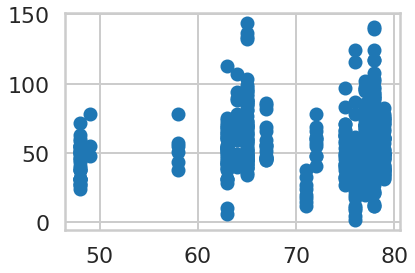

In [7]:
plt.scatter(red["Age_num"].to_numpy(), red["Tc..h."].to_numpy())

## processing part

In [8]:
occipital = red.loc[red["Region"] == "occipital"]
frontal = red.loc[red["Region"] == "frontal"]
reste = red.loc[(red["Region"] != "frontal") & (red["Region"] != "occipital")]

In [9]:
print(reste.shape)
reste.head()

(14, 7)


,Age,Condition,Tc..h.,Region,Time_division..DIV.,Age_num,TimeApparitionDIV
716,E78,control (mir),81.0,,0.0,78,-3.3750
717,E78,control (mir),66.0,,0.0,78,-2.7500
718,E78,control (mir),82.5,,0.0,78,-3.4375
719,E78,control (mir),49.5,,0.0,78,-2.0625
720,E78,control (mir),75.0,,0.0,78,-3.1250


## Plotting occipital (top) and frontal (bottom)
Be aware of the difference in the x scale

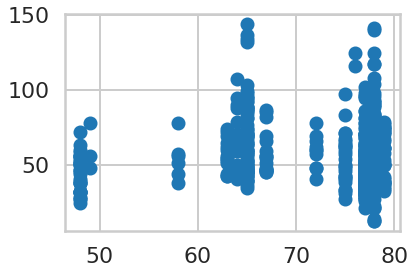

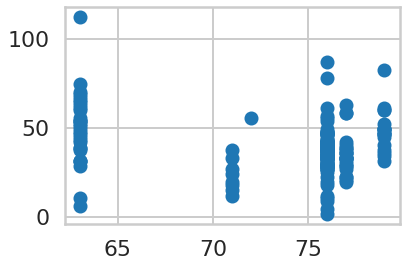

In [10]:
plt.scatter(occipital["Age_num"].to_numpy(), occipital["Tc..h."].to_numpy()); plt.show()
plt.scatter(frontal["Age_num"].to_numpy(), frontal["Tc..h."].to_numpy()); plt.show()

## Polynomial regression
Polynomial is a good choice to approximate Tc with respect to Age.

Just be aware that extrapolation (outside the data) cannot be taken into account and that
the sharpness / smoothness of the curve at one end neither.

The first is only embryonic day, the second is embryonic day + day in vitro

/home/nathan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.36098e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/nathan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.30125e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


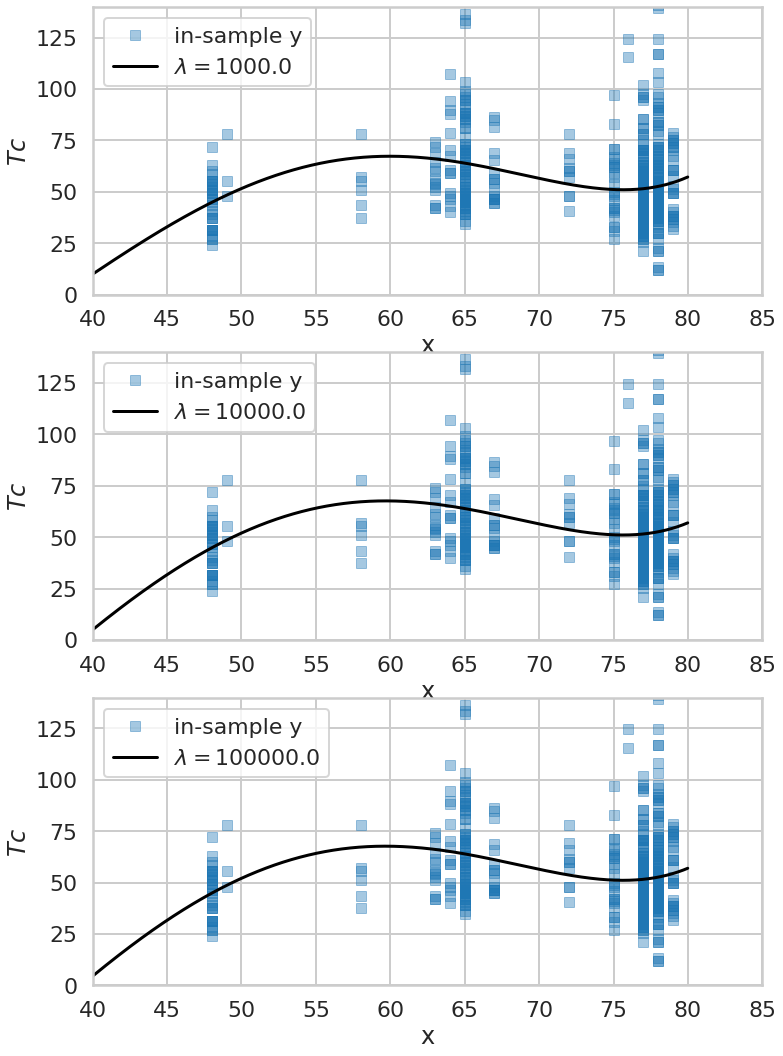

In [11]:
X_train, y_train = occipital["Age_num"].to_numpy(), occipital["Tc..h."].to_numpy()

d = 5 # Maximum polynomial degree
# You will create a grid of plots of this size (7 x 2)
lambdas = [1e3, 1e4, 1e5] # Various penalization parameters to try
grid_to_predict = np.arange(40, 80, .01) # Predictions will be made on this grid
rows = len(lambdas)
cols = 1

# Create training set and test set
Xtrain = PolynomialFeatures(d).fit_transform(X_train.reshape(-1,1))
test_set = PolynomialFeatures(d).fit_transform(grid_to_predict.reshape(-1,1))
fig, axs = plt.subplots(rows, cols, figsize=(12, 18)) # Set up plotting objects

for i, lam in enumerate(lambdas):
    # your code here
    ridge_reg = Ridge(alpha = lam) # Create regression object
    ridge_reg.fit(Xtrain, y_train) # Fit on regression object
    ypredict_ridge = ridge_reg.predict(test_set) # Do a prediction on the test set
    
    ### Provided code
    axs[i].plot(X_train, y_train, 's', alpha=0.4, ms=10, label="in-sample y") # Plot sample observations
    axs[i].plot(grid_to_predict, ypredict_ridge, 'k-', label=r"$\lambda =  {0}$".format(lam)) # Ridge regression prediction
    axs[i].set_ylabel('$Tc$') # y axis label
    axs[i].set_xlabel('$E day$') # y axis label
    axs[i].set_ylim((0, 140)) # y axis limits
    axs[i].set_xlim((40, 85)) # x axis limits
    axs[i].legend(loc='best') # legend
    axs[i].set_xlabel("x")


/home/nathan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.01208e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/nathan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.01208e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/nathan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.01208e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


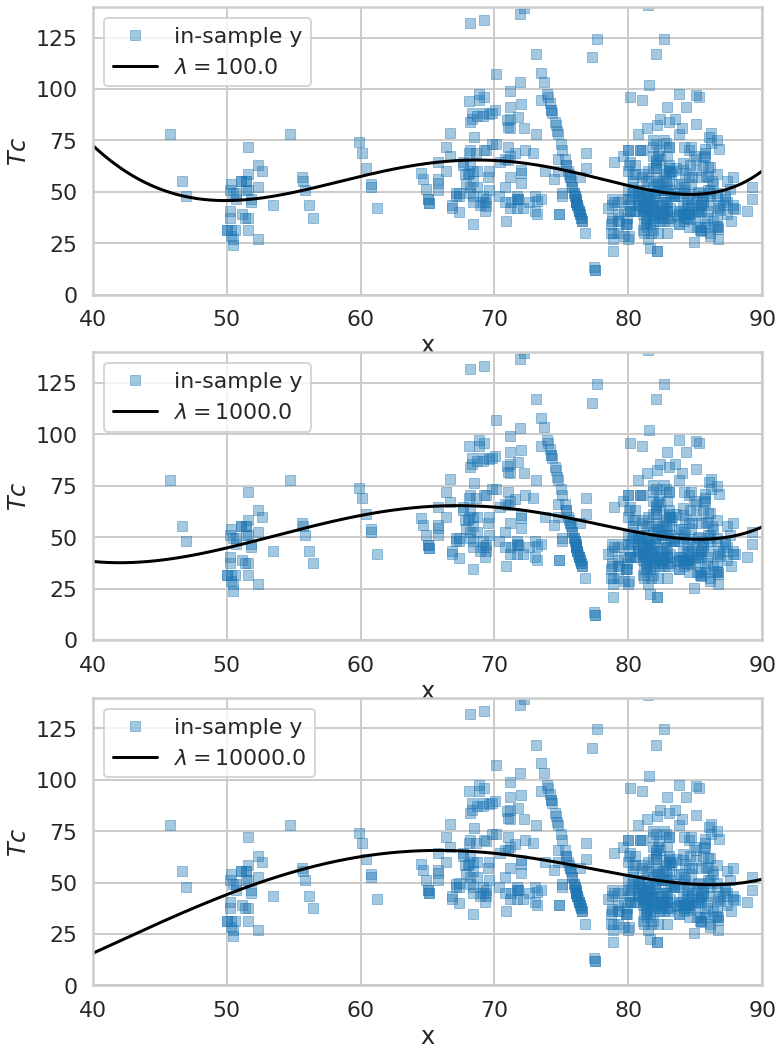

In [12]:
X_train = occipital["Age_num"].to_numpy() + occipital["TimeApparitionDIV"].to_numpy()
y_train = occipital["Tc..h."].to_numpy()


d = 5 # Maximum polynomial degree
# You will create a grid of plots of this size (7 x 2)
lambdas = [1e2, 1e3, 1e4] # Various penalization parameters to try
grid_to_predict = np.arange(40, 90, .01) # Predictions will be made on this grid
rows = len(lambdas)
cols = 1

# Create training set and test set
Xtrain = PolynomialFeatures(d).fit_transform(X_train.reshape(-1,1))
test_set = PolynomialFeatures(d).fit_transform(grid_to_predict.reshape(-1,1))

fig, axs = plt.subplots(rows, cols, figsize=(12, 18)) # Set up plotting objects

for i, lam in enumerate(lambdas):
    # your code here
    ridge_reg = Ridge(alpha = lam) # Create regression object
    ridge_reg.fit(Xtrain, y_train) # Fit on regression object
    ypredict_ridge = ridge_reg.predict(test_set) # Do a prediction on the test set
    
    ### Provided code
    axs[i].plot(X_train, y_train, 's', alpha=0.4, ms=10, label="in-sample y") # Plot sample observations
    axs[i].plot(grid_to_predict, ypredict_ridge, 'k-', label=r"$\lambda =  {0}$".format(lam)) # Ridge regression prediction
    axs[i].set_ylabel('$Tc$') # y axis label
    axs[i].set_xlabel('$E day$') # y axis label
    axs[i].set_ylim((0, 140)) # y axis limits
    axs[i].set_xlim((40, 90)) # x axis limits
    axs[i].legend(loc='best') # legend
    axs[i].set_xlabel("x")


In [13]:
# On choisit lamdba = 1e1
ridge_reg = Ridge(alpha = 1e3) # Create regression object
ridge_reg.fit(Xtrain, y_train)

/home/nathan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.01208e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge(alpha=1000.0)

### Plotting output (1 / Tc)
The parameter that is important for the future model is the output (nb cells per uni of time) which is basically the inverse of Tc

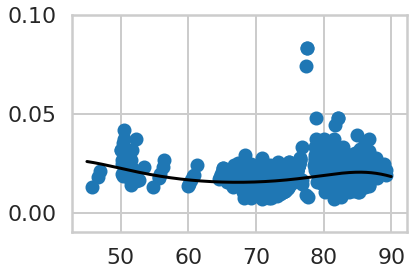

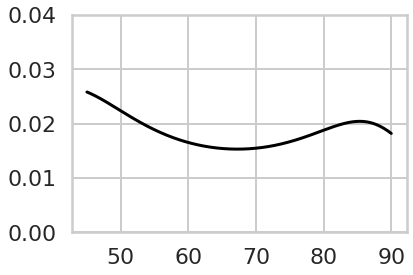

In [14]:
grid_to_predict = np.arange(45, 90, .01) # Predictions will be made on this grid
test_set = PolynomialFeatures(d).fit_transform(grid_to_predict.reshape(-1,1))
ypredict = 1 / ridge_reg.predict(test_set) # Do a prediction on the test set

### Plotting cell output (1 / Tc)
plt.scatter(X_train, 1 / y_train)
plt.plot(grid_to_predict, ypredict, 'k-')
plt.ylim((-0.01, 0.1)) # y axis limits
plt.show()
plt.plot(grid_to_predict, ypredict, 'k-')
plt.ylim((0.0, 0.04)) # y axis limits
plt.show()

In [29]:
for i, x in enumerate(ridge_reg.coef_):
    print(x)
    print("X^{i} = {x:.15f}".format(i=i, x=x))

0.0
X^0 = 0.000000000000000
-0.023973977538587335
X^1 = -0.023973977538587
-0.761568634472077
X^2 = -0.761568634472077
0.02559428761140972
X^3 = 0.025594287611410
-0.0003074969755615461
X^4 = -0.000307496975562
1.2642307585272326e-06
X^5 = 0.000001264230759


In [34]:
print("intercept", ridge_reg.intercept_)
for i, x in enumerate(ridge_reg.coef_):
    print("X^{i} = {x:.15f}".format(i=i, x=x))

intercept 277.36424309532794
X^0 = 0.000000000000000
X^1 = -0.023973977538587
X^2 = -0.761568634472077
X^3 = 0.025594287611410
X^4 = -0.000307496975562
X^5 = 0.000001264230759


277.36424309532794

## Regression with frontal data

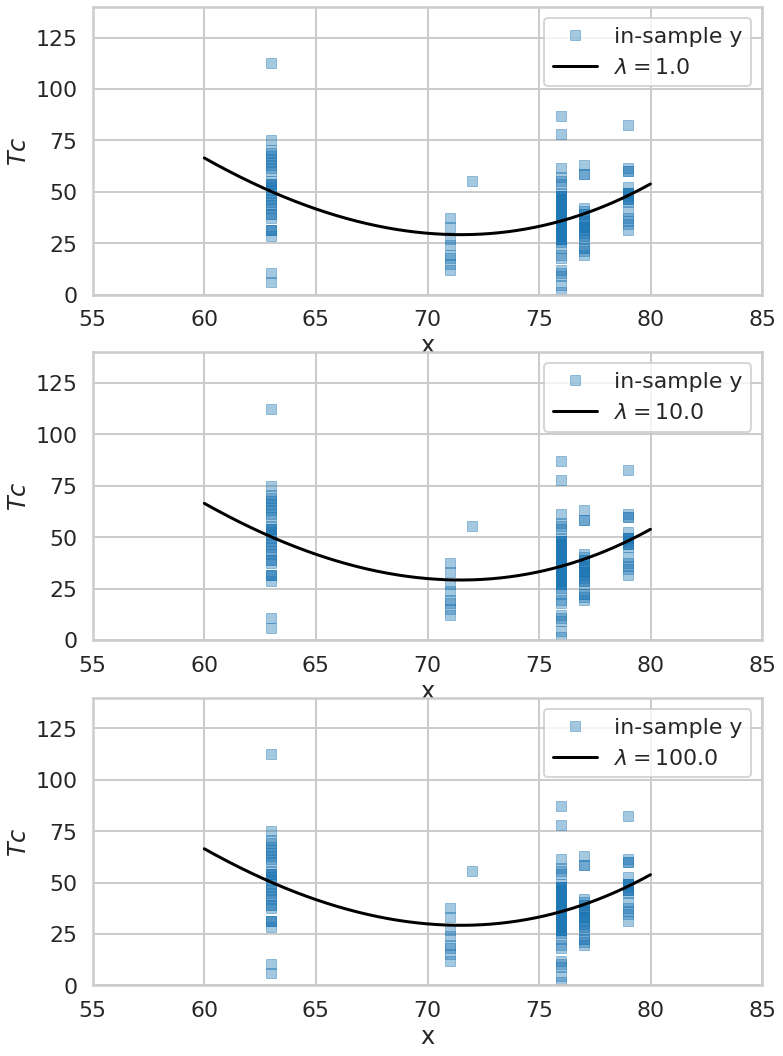

In [16]:
X_train2, y_train2 = frontal["Age_num"].to_numpy(), frontal["Tc..h."].to_numpy()


d2 = 3 # Maximum polynomial degree
# You will create a grid of plots of this size (7 x 2)
lambdas = [1e0, 1e1, 1e2] # Various penalization parameters to try
grid_to_predict = np.arange(60, 80, .01) # Predictions will be made on this grid
rows = len(lambdas)
cols = 1

# Create training set and test set
Xtrain2 = PolynomialFeatures(d2).fit_transform(X_train2.reshape(-1,1))
test_set = PolynomialFeatures(d2).fit_transform(grid_to_predict.reshape(-1,1))

fig, axs = plt.subplots(rows, cols, figsize=(12, 18)) # Set up plotting objects

for i, lam in enumerate(lambdas):
    # your code here
    ridge_reg2 = Ridge(alpha = lam) # Create regression object
    ridge_reg2.fit(Xtrain2, y_train2) # Fit on regression object
    ypredict_ridge = ridge_reg2.predict(test_set) # Do a prediction on the test set
    
    ### Provided code
    axs[i].plot(X_train2, y_train2, 's', alpha=0.4, ms=10, label="in-sample y") # Plot sample observations
    axs[i].plot(grid_to_predict, ypredict_ridge, 'k-', label=r"$\lambda =  {0}$".format(lam)) # Ridge regression prediction
    axs[i].set_ylabel('$Tc$') # y axis label
    axs[i].set_xlabel('$E day$') # y axis label
    axs[i].set_ylim((0, 140)) # y axis limits
    axs[i].set_xlim((55, 85)) # x axis limits
    axs[i].legend(loc='best') # legend
    axs[i].set_xlabel("x")
    

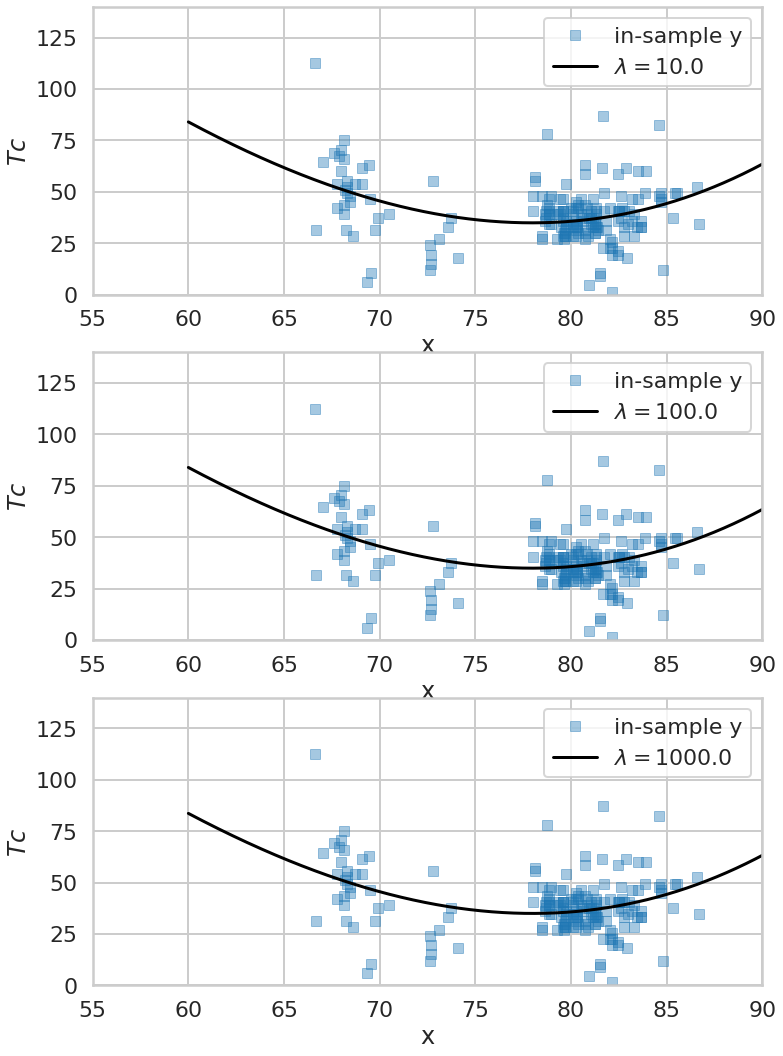

In [17]:
X_train2 = frontal["Age_num"].to_numpy() + frontal["TimeApparitionDIV"].to_numpy()
y_train2 = frontal["Tc..h."].to_numpy()


d2 = 3 # Maximum polynomial degree
# You will create a grid of plots of this size (7 x 2)
lambdas = [1e1, 1e2, 1e3] # Various penalization parameters to try
grid_to_predict = np.arange(60, 90, .01) # Predictions will be made on this grid
rows = len(lambdas)
cols = 1

# Create training set and test set
Xtrain2 = PolynomialFeatures(d2).fit_transform(X_train2.reshape(-1,1))
test_set = PolynomialFeatures(d2).fit_transform(grid_to_predict.reshape(-1,1))

fig, axs = plt.subplots(rows, cols, figsize=(12, 18)) # Set up plotting objects

for i, lam in enumerate(lambdas):
    # your code here
    ridge_reg2 = Ridge(alpha = lam) # Create regression object
    ridge_reg2.fit(Xtrain2, y_train2) # Fit on regression object
    ypredict_ridge = ridge_reg2.predict(test_set) # Do a prediction on the test set
    
    ### Provided code
    axs[i].plot(X_train2, y_train2, 's', alpha=0.4, ms=10, label="in-sample y") # Plot sample observations
    axs[i].plot(grid_to_predict, ypredict_ridge, 'k-', label=r"$\lambda =  {0}$".format(lam)) # Ridge regression prediction
    axs[i].set_ylabel('$Tc$') # y axis label
    axs[i].set_xlabel('$E day$') # y axis label
    axs[i].set_ylim((0, 140)) # y axis limits
    axs[i].set_xlim((55, 90)) # x axis limits
    axs[i].legend(loc='best') # legend
    axs[i].set_xlabel("x")
    

In [18]:
# On choisit lamdba = 1e1
ridge_reg2 = Ridge(alpha = 1e3) # Create regression object
ridge_reg2.fit(Xtrain2, y_train2)

Ridge(alpha=1000.0)

## Plotting output of frontal data

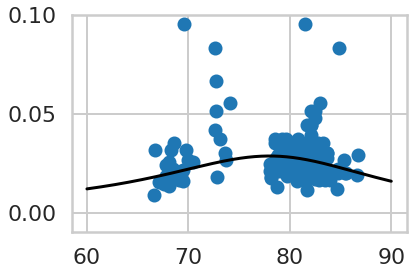

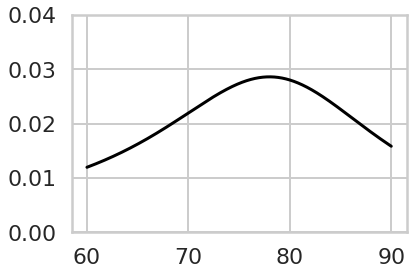

In [20]:
grid_to_predict = np.arange(60, 90, .01) # Predictions will be made on this grid
test_set = PolynomialFeatures(d2).fit_transform(grid_to_predict.reshape(-1,1))
ypredict = 1 / ridge_reg2.predict(test_set) # Do a prediction on the test set

### Plotting cell output (1 / Tc)
plt.scatter(X_train2, 1 / y_train2)
plt.plot(grid_to_predict, ypredict, 'k-')
plt.ylim((-0.01, 0.1)) # y axis limits
plt.show()
plt.plot(grid_to_predict, ypredict, 'k-')
plt.ylim((0.0, 0.04)) # y axis limits
plt.show()

In [21]:
for i, x in enumerate(ridge_reg2.coef_):
    print("X^{i} = {x:.15f}".format(i=i, x=x))

X^0 = 0.000000000000000
X^1 = -0.005557160118478
X^2 = -0.177581580564806
X^3 = 0.001518280008687


# Superposition Tc

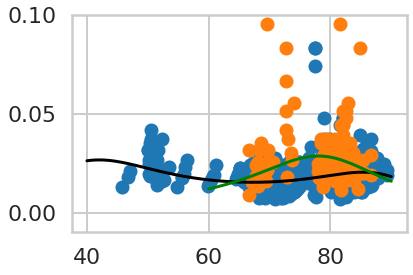

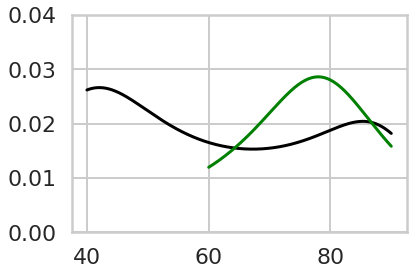

In [23]:
grid_to_predict1 = np.arange(40, 90, .01) # Predictions will be made on this grid
test_set1 = PolynomialFeatures(d).fit_transform(grid_to_predict1.reshape(-1,1))
grid_to_predict2 = np.arange(60, 90, .01) # Predictions will be made on this grid
test_set2 = PolynomialFeatures(d2).fit_transform(grid_to_predict2.reshape(-1,1))
ypredict1 = ridge_reg.predict(test_set1) # Do a prediction on the test set
ypredict2 = ridge_reg2.predict(test_set2) # Do a prediction on the test set

### Plotting cell output (1 / Tc)
plt.scatter(X_train, 1 / y_train)
plt.scatter(X_train2, 1 / y_train2)
plt.plot(grid_to_predict1, 1 / ypredict1, 'k-')
plt.plot(grid_to_predict2, 1 / ypredict2, 'g-')
plt.ylim((-0.01, 0.1)) # y axis limits
plt.show()
plt.plot(grid_to_predict1, 1 / ypredict1, 'k-')
plt.plot(grid_to_predict2, 1 / ypredict2, 'g-')
plt.ylim((0.0, 0.04)) # y axis limits
plt.show()

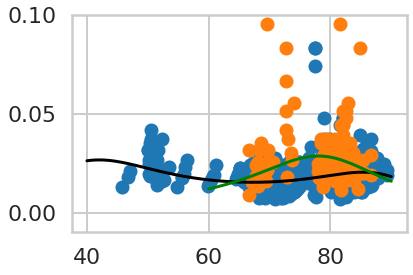

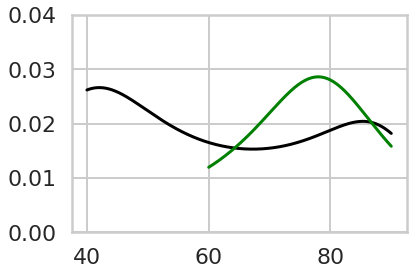

In [25]:
grid_to_predict1 = np.arange(40, 90, .01) # Predictions will be made on this grid
test_set1 = PolynomialFeatures(d).fit_transform(grid_to_predict1.reshape(-1,1))
grid_to_predict2 = np.arange(60, 90, .01) # Predictions will be made on this grid
test_set2 = PolynomialFeatures(d2).fit_transform(grid_to_predict2.reshape(-1,1))
ypredict1 = ridge_reg.predict(test_set1) # Do a prediction on the test set
ypredict2 = ridge_reg2.predict(test_set2) # Do a prediction on the test set

### Plotting cell output (1 / Tc)
plt.scatter(X_train, 1 / y_train)
plt.scatter(X_train2, 1 / y_train2)
plt.plot(grid_to_predict1, 1 / ypredict1, 'k-')
plt.plot(grid_to_predict2, 1 / ypredict2, 'g-')
plt.ylim((-0.01, 0.1)) # y axis limits
plt.show()
plt.plot(grid_to_predict1, 1 / ypredict1, 'k-')
plt.plot(grid_to_predict2, 1 / ypredict2, 'g-')
plt.ylim((0.0, 0.04)) # y axis limits
plt.show()

# Superposition output

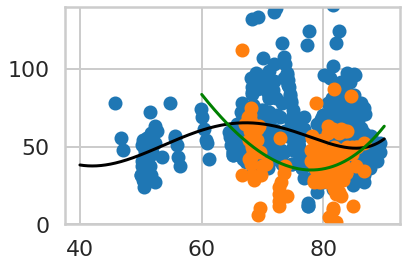

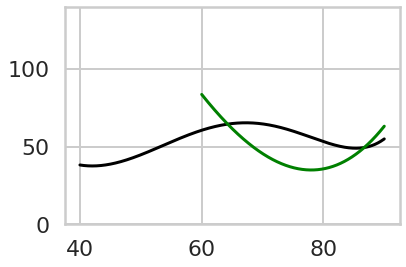

In [26]:
### Plotting cell output (1 / Tc)
plt.scatter(X_train, y_train)
plt.scatter(X_train2, y_train2)
plt.plot(grid_to_predict1, ypredict1, 'k-')
plt.plot(grid_to_predict2, ypredict2, 'g-')
plt.ylim((0, 140)) # y axis limits
plt.show()
plt.plot(grid_to_predict1, ypredict1, 'k-')
plt.plot(grid_to_predict2, ypredict2, 'g-')
plt.ylim((0, 140)) # y axis limits
plt.show()

We see that the shape seems to be rather synchronized than shifted (it's a bit shifted), and that output is bigger in frontal cortex meaning higher number of cells that are produced per progenitor).
However to be confident with the frontal shape, we should check at an earlier time (~E50-E60)

We can be confident for the interval 70-85 (for both) and 45-85 (for occipital)

# Superposition output with age correction for frontal

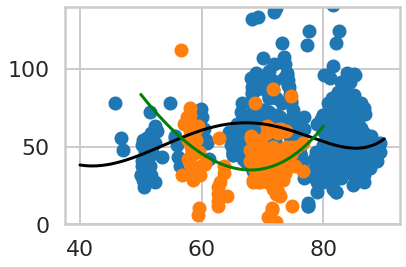

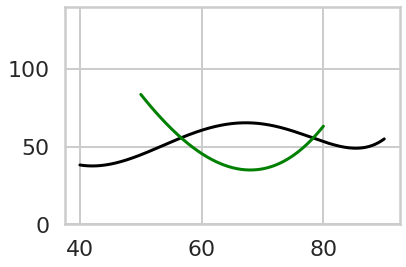

In [27]:
### Plotting cell output (1 / Tc)
plt.scatter(X_train, y_train)
plt.scatter(X_train2-10, y_train2)
plt.plot(grid_to_predict1, ypredict1, 'k-')
plt.plot(grid_to_predict2-10, ypredict2, 'g-')
plt.ylim((0, 140)) # y axis limits
plt.show()
plt.plot(grid_to_predict1, ypredict1, 'k-')
plt.plot(grid_to_predict2-10, ypredict2, 'g-')
plt.ylim((0, 140)) # y axis limits
plt.show()